In [137]:
#from __future__ import absolute_import, division, print_function

import sys
import skimage.io
import numpy as np
import caffe
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../')
sys.path.append('../lang_seg_model')

from lang_seg_model import lang_seg_model as segmodel
from util import processing_tools, im_processing, text_processing, eval_tools
import otb_config

from glob import glob, iglob
import xml.etree.ElementTree as ET

In [138]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Load config
config = otb_config.Config()

# Load the model
with open('./demo.prototxt', 'w') as f:
    f.write(str(segmodel.generate_model('val', config)))

caffe.set_device(config.gpu_id)
caffe.set_mode_gpu()

net = caffe.Net('./demo.prototxt', config.pretrained_model, caffe.TEST)

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(config.vocab_file)

Woman
woman in pink top and black pants


/home/zhenyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


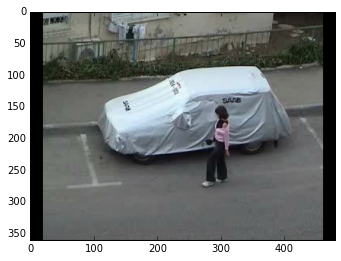

In [183]:
# input image and query text
k = 50
videofiles = sorted(glob('/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/*'))
videofile = videofiles[k]
video = videofile.split('/')[-1]
print(video)

start_frame = 1
if video == 'David':
    start_frame = 300
im_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/img/%04d.jpg' % (start_frame,)
query_file = '../OTB50/OTB50Entities/' + video + '.xml'

# Firstly, select query
root = ET.parse(query_file).getroot()
# querier = prettify( querier )
query = root[3][1].text
print(query)

# Secondly, get gt box
gt_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/groundtruth_rect.txt'
try:
    gt_boxes = np.loadtxt(gt_file, delimiter=',').astype(int)
except ValueError:
    gt_boxes = np.loadtxt(gt_file, delimiter='\t').astype(int)
gt_box = gt_boxes[0, :]
gt_box[2] = gt_box[0] + gt_box[2] - 1;
gt_box[3] = gt_box[1] + gt_box[3] - 1;

#im_file = './demo_data/38100.jpg'
#query = 'brown liquor bottle in the center'

# ###
# Run on the input image and query text
text_seq_val = np.zeros((config.T, config.N), dtype=np.float32)
imcrop_val = np.zeros((config.N, config.input_H, config.input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)
im_h, im_w = im.shape[:2]
if im_h > im_w:
#    im = skimage.transform.resize(im, [480, 360])
    im = im_processing.resize_and_pad(im, 480, 360);
else:
#    im = skimage.transform.resize(im, [360, 480])
    im = im_processing.resize_and_pad(im, 360, 480);

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)

processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, config.input_H, config.input_W))
if processed_im.ndim == 2:
    processed_im = np.tile(processed_im[:, :, np.newaxis], (1, 1, 3))
imcrop_val[0, :] = processed_im.astype(np.float32) - segmodel.channel_mean
imcrop_val = imcrop_val.transpose((0, 3, 1, 2))
imcrop_val = imcrop_val[:, ::-1, :, :]

spatial_val = processing_tools.generate_spatial_batch(config.N, config.featmap_H, config.featmap_W)
spatial_val = spatial_val.transpose((0, 3, 1, 2))

text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, config.T)
cont_val = text_processing.create_cont(text_seq_val)

dummy_label = np.zeros((config.N, 1, config.input_H, config.input_W), dtype=np.float32)

# Forward pass to get response map
net.blobs['language'].data[...] = text_seq_val
net.blobs['cont'].data[...] = cont_val
net.blobs['image'].data[...] = imcrop_val
net.blobs['spatial'].data[...] = spatial_val
net.blobs['label'].data[...] = dummy_label

net.forward()

upscores = net.blobs['upscores'].data[...].copy()
upscores = np.squeeze(upscores)

# Final prediction
#prediction = im_processing.resize_and_crop(upscores>0, *im.shape[:2]).astype(np.bool)
upscores = sigmoid(upscores)
upscores = upscores*255
prediction = im_processing.resize_and_crop(upscores.astype(np.int32), *im.shape[:2])


query text = 'woman in pink top and black pants'


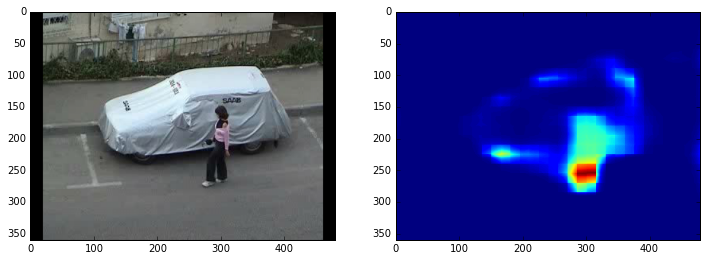

In [184]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)

array([[  6.71124800e-09,   2.95674907e-09,   1.24014965e-09, ...,
          8.54985804e-10,   2.01806305e-09,   4.11071222e-09],
       [  2.62888933e-09,   1.24973798e-09,   4.99317920e-10, ...,
          3.36364353e-10,   8.15074119e-10,   1.65334602e-09],
       [  1.25127164e-09,   5.58108892e-10,   1.99910963e-10, ...,
          1.17930943e-10,   2.93345265e-10,   6.84573953e-10],
       ..., 
       [  8.66538168e-15,   1.97120703e-15,   4.48274664e-16, ...,
          8.45294022e-14,   3.07382293e-13,   1.09501113e-12],
       [  3.26973217e-14,   8.23076992e-15,   1.80498655e-15, ...,
          2.71640837e-13,   9.35916275e-13,   3.01106145e-12],
       [  9.85609706e-14,   2.58779509e-14,   6.32070046e-15, ...,
          7.56310704e-13,   2.59700443e-12,   8.87871027e-12]], dtype=float32)

190.69713